In [1]:
from pyspark.sql import SparkSession

import pandas as pd 
import matplotlib.pyplot as plt 

from pyspark.sql.functions import countDistinct, desc, to_timestamp, udf, col
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, StringType

import json

%matplotlib inline

In [2]:
# https://central.sonatype.com/search?q=spark-sql-kafka

# https://spark.apache.org/docs/latest/streaming/structured-streaming-kafka-integration.html

# https://hub.docker.com/r/jupyter/pyspark-notebook/tags?name=spark

# https://central.sonatype.com/artifact/org.apache.spark/spark-sql-kafka-0-10_2.12/3.5.0

spark = (
    SparkSession.builder
      .appName("eda")
      .config("spark.driver.memory", "6g")
      .config("spark.executor.memory", "6g")
      .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.0")
      .getOrCreate()
)

In [3]:
spark

In [4]:
spark.version

'3.5.0'

In [5]:
spark.sparkContext._jsc


JavaObject id=o22

In [6]:
spark.sparkContext.getConf().get("spark.jars.packages")


'org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.0'

In [7]:
spark.sparkContext._jvm.scala.util.Properties.versionString()


'version 2.12.18'

In [8]:
# (base) jovyan@3d4ee2b03dca:~$ spark-submit --version
# Welcome to
#       ____              __
#      / __/__  ___ _____/ /__
#     _\ \/ _ \/ _ `/ __/  '_/
#    /___/ .__/\_,_/_/ /_/\_\   version 3.5.0
#       /_/
                        
# Using Scala version 2.12.18, OpenJDK 64-Bit Server VM, 17.0.8.1
# Branch HEAD
# Compiled by user ubuntu on 2023-09-09T01:53:20Z
# Revision ce5ddad990373636e94071e7cef2f31021add07b
# Url https://github.com/apache/spark
# Type --help for more information.

In [9]:
df = spark.read.csv("customers-1000000.csv", header=True, inferSchema=True)


In [10]:
df.printSchema()

root
 |-- Index: integer (nullable = true)
 |-- Customer Id: string (nullable = true)
 |-- First Name: string (nullable = true)
 |-- Last Name: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Phone 1: string (nullable = true)
 |-- Phone 2: string (nullable = true)
 |-- Email: string (nullable = true)
 |-- Subscription Date: date (nullable = true)
 |-- Website: string (nullable = true)



In [11]:
df.show(5)

+-----+---------------+----------+---------+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+
|Index|    Customer Id|First Name|Last Name|             Company|       City|             Country|             Phone 1|             Phone 2|               Email|Subscription Date|             Website|
+-----+---------------+----------+---------+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+
|    1|138fB5315da5fE9|    Jeanne|  Ferrell|          Wilcox-Fox|Tonichester|British Virgin Is...|001-995-820-0140x...|       (757)324-8634|aaronwoods@walter...|       2020-03-27|https://www.romer...|
|    2|b0d61acAc72A388|       Ian| Browning|         Meadows Inc|  Colontown|         El Salvador|        218-383-6764|+1-213-212-0464x0742|zschultz@blevins-...|       2021-03-12|   https://ford.c

In [12]:
# number of unique counties
df.select("Country").distinct().count()

243

In [13]:
# number of unique cities
df.select("City").distinct().count()

114893

In [14]:
# which country has the most number of customers

cust_count_df = df.groupBy("Country").agg((countDistinct("Customer Id")).alias("customer_count"))

cust_count_df.show(5)


+--------------------+--------------+
|             Country|customer_count|
+--------------------+--------------+
|                Chad|          4056|
|            Anguilla|          4049|
|            Paraguay|          3992|
|               Macao|          4211|
|Heard Island and ...|          4095|
+--------------------+--------------+
only showing top 5 rows



In [15]:
# which country has the most number of cities

city_count_df = df.groupBy("Country").agg((countDistinct("City")).alias("city_count"))

city_count_df.show(5)



+--------------------+----------+
|             Country|city_count|
+--------------------+----------+
|                Chad|      3881|
|            Anguilla|      3844|
|            Paraguay|      3809|
|               Macao|      4032|
|Heard Island and ...|      3918|
+--------------------+----------+
only showing top 5 rows



In [16]:
# Joining

count_df = cust_count_df.join(city_count_df, on = "Country")

count_df.show(5)


+--------------------+--------------+----------+
|             Country|customer_count|city_count|
+--------------------+--------------+----------+
|                Chad|          4056|      3881|
|            Anguilla|          4049|      3844|
|            Paraguay|          3992|      3809|
|               Macao|          4211|      4032|
|Heard Island and ...|          4095|      3918|
+--------------------+--------------+----------+
only showing top 5 rows



In [17]:
# which country has the most number of customers

count_df = count_df.orderBy(desc("customer_count"))
count_df.show(5)


+--------------------+--------------+----------+
|             Country|customer_count|city_count|
+--------------------+--------------+----------+
|               Korea|          8114|      7358|
|               Congo|          8112|      7421|
|        Saudi Arabia|          4249|      4061|
|Holy See (Vatican...|          4240|      4041|
|               Haiti|          4237|      4041|
+--------------------+--------------+----------+
only showing top 5 rows



In [18]:
df = df.withColumn("date", to_timestamp("Subscription Date"))
df.show(1)

+-----+---------------+----------+---------+----------+-----------+--------------------+--------------------+-------------+--------------------+-----------------+--------------------+-------------------+
|Index|    Customer Id|First Name|Last Name|   Company|       City|             Country|             Phone 1|      Phone 2|               Email|Subscription Date|             Website|               date|
+-----+---------------+----------+---------+----------+-----------+--------------------+--------------------+-------------+--------------------+-----------------+--------------------+-------------------+
|    1|138fB5315da5fE9|    Jeanne|  Ferrell|Wilcox-Fox|Tonichester|British Virgin Is...|001-995-820-0140x...|(757)324-8634|aaronwoods@walter...|       2020-03-27|https://www.romer...|2020-03-27 00:00:00|
+-----+---------------+----------+---------+----------+-----------+--------------------+--------------------+-------------+--------------------+-----------------+--------------------+-

In [19]:
df.printSchema()

root
 |-- Index: integer (nullable = true)
 |-- Customer Id: string (nullable = true)
 |-- First Name: string (nullable = true)
 |-- Last Name: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Phone 1: string (nullable = true)
 |-- Phone 2: string (nullable = true)
 |-- Email: string (nullable = true)
 |-- Subscription Date: date (nullable = true)
 |-- Website: string (nullable = true)
 |-- date: timestamp (nullable = true)



In [20]:
max_date = df.select(F.max("date")).collect()[0][0]
max_date


datetime.datetime(2022, 5, 29, 0, 0)

In [21]:
df.filter(df['date']==max_date).show(5)


+-----+---------------+-----------+----------+--------------------+--------------+--------------------+--------------------+-------------------+--------------------+-----------------+--------------------+-------------------+
|Index|    Customer Id| First Name| Last Name|             Company|          City|             Country|             Phone 1|            Phone 2|               Email|Subscription Date|             Website|               date|
+-----+---------------+-----------+----------+--------------------+--------------+--------------------+--------------------+-------------------+--------------------+-----------------+--------------------+-------------------+
|  860|A087d8CF7E24396|     Connie|Hutchinson|      Hopkins-Reeves|     Karlaside|          Azerbaijan|001-199-101-1344x...|       220.882.7521|josephrodriguez@b...|       2022-05-29|   https://ward.net/|2022-05-29 00:00:00|
| 1023|FfCF2f6f304b4Aa|     Briana|      Khan|       Garner-Bowers|  Shelleyshire|             Comor

In [22]:
df.filter(df['date']==max_date).count() 


1140

In [23]:
rows = (
    count_df
      .limit(5)
      .collect()
)

countries = [r["Country"] for r in rows]
counts = [r["customer_count"] for r in rows]

In [24]:
countries

['Korea', 'Congo', 'Saudi Arabia', 'Holy See (Vatican City State)', 'Haiti']

In [25]:
counts

[8114, 8112, 4249, 4240, 4237]

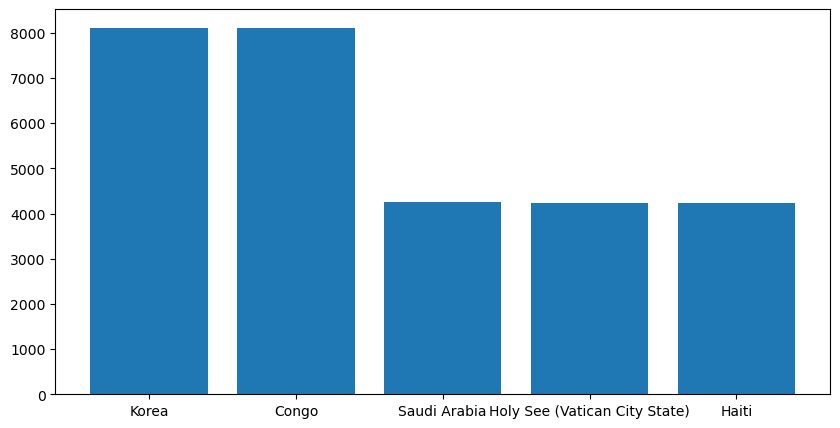

In [26]:
plt.figure(figsize = (10,5))
plt.bar(countries, counts)
plt.show()

In [27]:
# pandas will likely to break 

top5 = count_df.orderBy(desc("customer_count")).limit(5)

top5_pd = top5.toPandas()

top5_pd.head()


,Country,customer_count,city_count
0,Korea,8114,7358
1,Congo,8112,7421
2,Saudi Arabia,4249,4061
3,Holy See (Vatican City State),4240,4041
4,Haiti,4237,4041


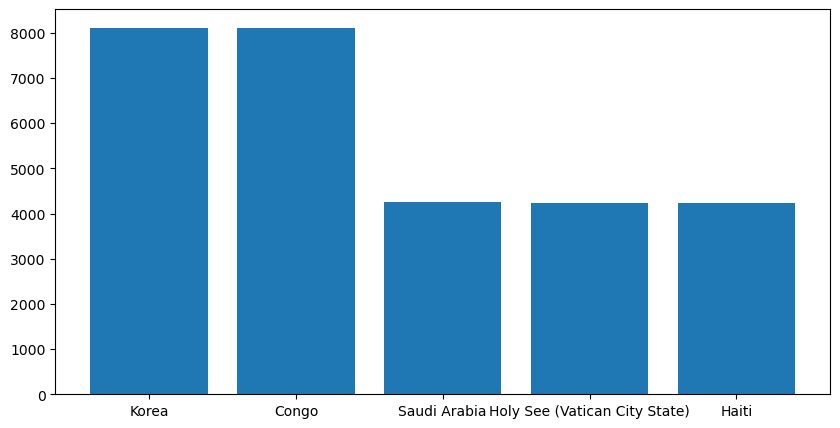

In [28]:
# bar plot

plt.figure(figsize = (10,5))

plt.bar(top5_pd['Country'][:5], top5_pd['customer_count'][:5])

plt.show()
